# Scratchpad for testing out graphlab with project data

In [1]:
import json
import numpy as np
import graphlab as gl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

This non-commercial license of GraphLab Create is assigned to windsurf_dean@yahoo.com and will expire on May 26, 2017. For commercial licensing options, visit https://dato.com/buy/.


[INFO] graphlab.cython.cy_server: GraphLab Create v1.10.1 started. Logging: /tmp/graphlab_server_1467512033.log


In [79]:
gl.__VERSION__

'1.10.1'

## Load in user-item-rating data...

In [2]:
# create Pandas DF with data pulled from Postgres (restaurant only reviews)
df = pd.read_csv('data_analysis/user_reviews.csv', header=None,
                 names=['user_id', 'business_id', 'business_name', 'stars', 'locale'])

In [3]:
df.head(5)

,user_id,business_id,biz_name,stars,locale
0,Ouus3lC3Xk3YRGx4ptd_4A,DW6SI2KxcfXBHeo9jEr4lQ,Pyramid Cafe,2,"Las Vegas, NV"
1,dz_sBsL69aWzsxksT2O_Mg,DW6SI2KxcfXBHeo9jEr4lQ,Pyramid Cafe,2,"Las Vegas, NV"
2,zyI-u0C1YOzp5v1j2wuCOQ,DW6SI2KxcfXBHeo9jEr4lQ,Pyramid Cafe,3,"Las Vegas, NV"
3,vyfsQo-estP8EfiIFMsL6g,DW6SI2KxcfXBHeo9jEr4lQ,Pyramid Cafe,3,"Las Vegas, NV"
4,lxZSVeJz6KEBW1nlA3JKJg,DW6SI2KxcfXBHeo9jEr4lQ,Pyramid Cafe,1,"Las Vegas, NV"


In [280]:
df.to_csv('reviews.csv', columns=['user_id','business_id','stars'])

In [155]:
df.groupby(['user_id', 'business_id', 'stars']).count()

biz_name  locale
user_id                business_id            stars                  
--0KsjlAThNWua2Pr4HStQ DoKUOUwAsWrlRY6ehzQV_w 4             1       1
                       NjHwPn2d3TL_xxnheXoSmw 3             1       1
                       UG1che-DRtvE45Ni2bqwbA 5             1       1
                       fUlzYKXFTMFEDQtjzm6GXA 4             1       1
                       k-ClRJsPYJtsI8NRtiLdTA 4             1       1
                       s4QDG7jg9JafcugkggE6Xg 5             1       1
--0mI_q_0D1CdU4P_hoImQ xxOQ7h6s3InV8o8DOVHlMA 5             1       1
--2QZsyXGz1OhiD4-0FQLQ 0_LZEAYsexEZS-OFTjdjNQ 4             1       1
                       IRYj1b1-mlXqABVsl9SoqQ 5             1       1
                       tqu42L0qXzkvYKSruOz0IA 5             1       1
--37T3V10ZeoJ1Il7D2Wzw r69rxmc9pdU4AnZkBhTNLA 3             1       1
--4TkB_iDShmg41Y_QW9nw 0Zec6RiFV6h6TbOFb7xu3A 5             1       1
                       9kWnvBSD2AJ2liXnvGbW1g 5             1       1
                       AVQMHeyByhkkYEeDbH9HbQ 5             1       1
                       AgJbkqR-wre409if4fTbWQ 5             1       1
                       DfLML2IlhUqztTBURxOAxg 5             1       1
                       IgQa-Ig5wWMhDQRIWpbEgQ 5             1       1
                       JImJictLIE48_O1z-l2TGw 4             1       1
                       NR_8LIX-oG50jUQpziBnWQ 5             1       1
                       PdWe3jF9YEu5fWBiQXZIgg 2             1       1
                       RShrvt5oIS40FrcX6bCHSg 4             1       1
                       VEojEXbJ81eiPLSSF9jNEQ 4             1       1
                       VjzclBdSXmf6uNrD0DG2bg 4             1       1
                       WLDWl3QyQCeZ7EnHxH6Pwg 5             1       1
                       WZNU4bQJJHr3p4SjnjVrkg 4             1       1
                       Y9D61SRDiTAYJeaVbqvbFg 5             1       1
                       _YswYrpv6YdO3R3CP8R8oQ 4             1       1
                       b9dv7Q0A8XcJ44zzTDJeYw 4             1       1
                       c28zcdBp82B9Vli3WXn8zA 5             1       1
                       e0vubCKi8KD8zC2C6FdbuQ 5             1       1
...                                                       ...     ...
zztT9KKp0rmJRMeMl4CqzQ A8Khz3eeqIFFGaXurg3hxw 4             1       1
                       ilJiRYZgxjrEu2iexKu-pQ 1             1       1
                       sbsFamEj5wDxNAjUKrMcSw 4             1       1
                       wP5849J1DKB2KS3M6UwOAg 1             1       1
zzu_HGDO-nv0gHivZrKdpQ -HK7dIj7Eyx0JsfDzgbFKw 3             1       1
                       GXqBm5N0yZ3-rCd6hgUM7w 4             1       1
                       c_ZoCRssEFl7cKul3Wzm4Q 4             1       1
                       wr3bTAXlo6aB5LIbIx6ueQ 5             1       1
zzvGAKv1D1fdUwCvXEeQnA TnUgQXUHtx8LwJSfkeylGg 4             1       1
                       gltXCxQnlgFJLFcZkwwTBA 4             1       1
zzvflqB4xAcKFbIbS6HSOw 2e2e7WgqU1BnpxmQL5jbfw 5             1       1
                       7_fiK6AQbcBlAXsoS7QZRw 4             1       1
                       E-vpjU-T7ssWsswziJkJFA 3             1       1
                       IRYj1b1-mlXqABVsl9SoqQ 4             1       1
                       co0vxQ8ecXiBy2sGDeHi8A 5             1       1
                       nhToFLPoqNixNbRK4-xFQg 4             1       1
                       vvur3WRgdgnhYoMUXMZZCA 5             1       1
zzvrDmRAYdvIVRGszSFPGQ OgnHyXXqElaPgs7isOrdBQ 5             1       1
                       _w2wIsBh-1M1ZCed2KjLlw 5             1       1
zzx_41wDUNxpcgrdOtERvw 6nfTUgP3UvQ_jhnT8kCpew 3             1       1
                       Aenlydbbh9ieUGn7X-X1cw 4             1       1
                       CrwzX70X2XV1hlGhk30nYQ 3             1       1
                       IkukcWBvBl10_5VPbx-Liw 4             1       1
                       _leflhF7uTuhDeGqXY6Kuw 2             1       1
                                              4             1  

In [6]:
# store the observation data in Graphlab's SFrame type
sf_obs = gl.SFrame(df[['user_id', 'business_id', 'stars']])

In [8]:
sf_obs.head(5)

user_id,business_id,stars
Ouus3lC3Xk3YRGx4ptd_4A,DW6SI2KxcfXBHeo9jEr4lQ,2
dz_sBsL69aWzsxksT2O_Mg,DW6SI2KxcfXBHeo9jEr4lQ,2
zyI-u0C1YOzp5v1j2wuCOQ,DW6SI2KxcfXBHeo9jEr4lQ,3
vyfsQo-estP8EfiIFMsL6g,DW6SI2KxcfXBHeo9jEr4lQ,3
lxZSVeJz6KEBW1nlA3JKJg,DW6SI2KxcfXBHeo9jEr4lQ,1


In [277]:
sf_obs.num_rows()

1363242

# Quick EDA

## Group reviews by users...

In [195]:
# number of reviews by user (388k distinct users)
review_count_by_user = sf_obs.groupby('user_id', [gl.aggregate.COUNT()]).sort('Count', ascending=False)#['Count']
review_count_by_user[0:5]

user_id,Count
DrWLhrK8WMZf7Jb-Oqc7ww,817
9A2-wSoBUxlMd3LwmlGrrQ,782
3gIfcQq5KxAegwCPXc83cQ,754
Iu3Jo9ROp2IWC9FwtWOaUQ,666
kGgAARL2UmvCcTRfiscjug,665


In [267]:
review_count_by_user.filter_by('DrWLhrK8WMZf7Jb-Oqc7ww', 'user_id')

user_id,Count
DrWLhrK8WMZf7Jb-Oqc7ww,817


In [183]:
# how many times have the same user reviewed the same restaurant?
unique_user_items = sf_obs.groupby(['user_id', 'business_id'],
                                   {'count': gl.aggregate.COUNT(),
                                    'avg_rating': gl.aggregate.AVG('stars'),
                                    'ratings': gl.aggregate.CONCAT('stars')}) \
                          .sort('count', ascending=False)

unique_user_items

business_id,user_id,count,ratings,avg_rating
T1jYZFB_7cqdhuvzpxfFWQ,q200TCFOheJfS_MvvwMfJw,29,"[3, 4, 4, 3, 2, 3, 4, 3,3, 3, 4, 3, 3, 3, 3, 2, ...",3.13793103448
6LoNRotewF81fxka6L_8Jw,q200TCFOheJfS_MvvwMfJw,19,"[5, 3, 4, 5, 5, 4, 5, 3,3, 5, 5, 5, 5, 5, 5, 5, ...",4.57894736842
8aPTQeDYOMNEu907WfflCQ,_Q4Ks28-Jks-TjFT-YXw_A,18,"[5, 4, 4, 4, 4, 4, 4, 4,4, 3, 5, 4, 4, 4, 4, 4, ...",4.05555555556
yumgsa9m02CACzq0dHZP7Q,q200TCFOheJfS_MvvwMfJw,18,"[3, 4, 4, 4, 4, 4, 4, 3,3, 4, 4, 3, 3, 5, 2, 4, ...",3.55555555556
iaEqryy7OwAOAQkLWDBquQ,kG8jkVFgOAOq6Ht6RvAjEQ,14,"[4, 4, 5, 5, 5, 5, 5, 5,5, 5, 5, 5, 5, 5] ...",4.85714285714
QJlab4DqvBRJPUfg7Vn5ZQ,sDmgmT9RloG4sWpOu2QxnQ,13,"[5, 5, 5, 5, 5, 5, 5, 5,5, 4, 3, 5, 3] ...",4.61538461538
H9sWBAMvZFbSxbL6NmHyQQ,I3YCZ949bRqm4vVW3VJdwA,13,"[1, 1, 1, 2, 4, 2, 5, 5,2, 1, 5, 1, 1] ...",2.38461538462
puy0PzIcCgR3KWJI7llBFQ,_Q4Ks28-Jks-TjFT-YXw_A,12,"[4, 4, 4, 4, 4, 4, 5, 4,2, 4, 5, 3] ...",3.91666666667
NYg-hgqjQvq5RDRcV7iv8A,6PbjXuKOBGDe58rE85bl_g,12,"[5, 5, 5, 5, 5, 5, 5, 5,5, 5, 5, 5] ...",5.0
EQxbEKkHxNvRT_-S5A-Gcw,l-q56HHPUCi_LcJbuT-_Xw,11,"[5, 1, 5, 4, 5, 5, 2, 5,2, 5, 5] ...",4.0


In [268]:
unique_user_items.filter_by('DrWLhrK8WMZf7Jb-Oqc7ww', 'user_id')

business_id,user_id,count,ratings,avg_rating
rVUEZpHQfWI_3kt0lBwaxQ,DrWLhrK8WMZf7Jb-Oqc7ww,5,"[4, 4, 4, 4, 4]",4.0
vMeO4qFGHvu8ZyMsH0LDdw,DrWLhrK8WMZf7Jb-Oqc7ww,5,"[1, 3, 4, 3, 2]",2.6
aLMStInNBczJKtIJFMlwJA,DrWLhrK8WMZf7Jb-Oqc7ww,5,"[4, 4, 4, 4, 3]",3.8
ytpmoIty7loFB8kRYRtJHw,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[5, 5, 5, 4]",4.75
ymSMV5wMjFwcusoGRaqDWA,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[4, 2, 4, 5]",3.75
z3yFuLVrmH-3RJruPEMYKw,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[3, 3, 1, 3]",2.5
9SKdOoDHcFoxK5ZtsgHJoA,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[3, 4, 2, 3]",3.0
Q8OMwgekiTtgClSiRcQcSw,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[3, 3, 4, 3]",3.25
n6Zz_KdxcUou8b2MSoz2tw,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[3, 3, 3, 3]",3.0
v7OwbHgNgy_VQ9eP5FjvUA,DrWLhrK8WMZf7Jb-Oqc7ww,4,"[5, 5, 3, 4]",4.25


In [184]:
# group reviews by users, against distinct restaurants.
# Some users reviewed same restaurants multiple times!!!
restaurants_by_user = unique_user_items.groupby('user_id',
                                                {'count':gl.aggregate.COUNT(),
                                                 'restaurants':gl.aggregate.CONCAT('business_id','avg_rating')}) \
                                       .sort('count', ascending=False)
restaurants_by_user

user_id,count,restaurants
9A2-wSoBUxlMd3LwmlGrrQ,768,"{'IjhfUYq7ipHUfm8GeMTJnA': 3.0, ..."
3gIfcQq5KxAegwCPXc83cQ,688,"{'rZbHg4ACfN3iShdsT47WKQ': 4.0, ..."
DrWLhrK8WMZf7Jb-Oqc7ww,637,"{'rZbHg4ACfN3iShdsT47WKQ': 1.0, ..."
Iu3Jo9ROp2IWC9FwtWOaUQ,618,"{'3w5gd4EuSc75UKYMJiNUPA': 5.0, ..."
kGgAARL2UmvCcTRfiscjug,600,"{'Shy4HqmyEewCLvq7Ub3Whg': 3.0, ..."
pEVf8GRshP9HUkSpizc9LA,598,"{'rZbHg4ACfN3iShdsT47WKQ': 5.0, ..."
ia1nTRAQEaFWv0cwADeK7g,581,"{'lfaZQpkJWKl_DL8FEfAvJw': 2.0, ..."
uZbTb-u-GVjTa2gtQfry5g,524,"{'1ldDbggHHgPlj3k0SpBTKQ': 2.0, 'kIco4kv- ..."
90a6z--_CUrl84aCzZyPsg,490,"{'e5gB2kDFaodtxMTa53C29g': 4.0, '5N9bWl5zWuDX- ..."
glRXVWWD6x1EZKfjJawTOg,464,"{'1ldDbggHHgPlj3k0SpBTKQ': 3.0, ..."


In [266]:
restaurants_by_user.filter_by('q200TCFOheJfS_MvvwMfJw', 'user_id')#['restaurants']

user_id,count,restaurants
q200TCFOheJfS_MvvwMfJw,38,{'paR-TLy42ZmBWhahAxCWAw': ...


In [269]:
restaurants_by_user.filter_by('DrWLhrK8WMZf7Jb-Oqc7ww', 'user_id')

user_id,count,restaurants
DrWLhrK8WMZf7Jb-Oqc7ww,637,"{'rZbHg4ACfN3iShdsT47WKQ': 1.0, ..."


### Save file 'restaurants_by_user.json'

In [274]:
restaurants_by_user.export_json('restaurants_by_user.json', orient='records')

In [279]:
restaurants_by_user.export_csv('restaurants_by_user.csv')

In [278]:
restaurants_by_user.num_rows()

388612

In [128]:
# review_count_by_user.show()

Canvas is accessible via web browser at the URL: http://localhost:59179/index.html
Opening Canvas in default web browser.


In [ ]:
# df_cat_full.head().T[250:]

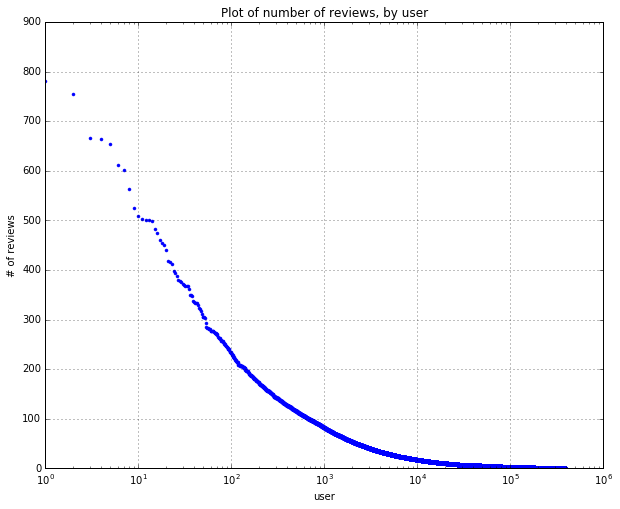

In [202]:
plt.figure(figsize=(10,8))
plt.semilogx(review_count_by_user['Count'], '.');
plt.grid()
plt.xlabel('user')
plt.ylabel('# of reviews')
plt.title('Plot of number of reviews, by user')

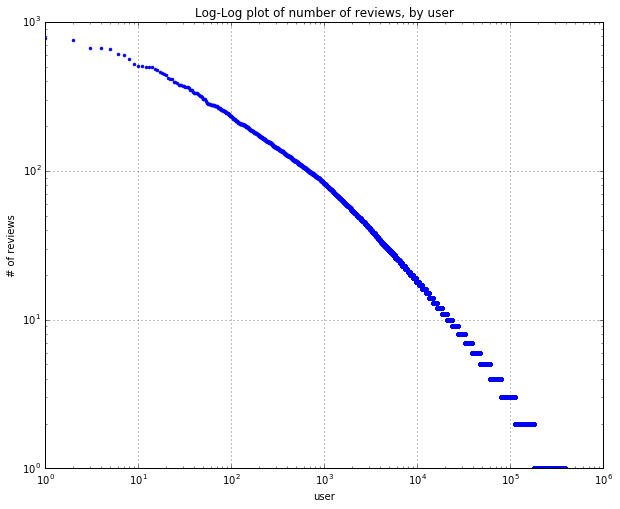

In [203]:
plt.figure(figsize=(10,8))
plt.loglog(review_count_by_user['Count'], '.');
plt.grid()
plt.xlabel('user')
plt.ylabel('# of reviews')
plt.title('Log-Log plot of number of reviews, by user')

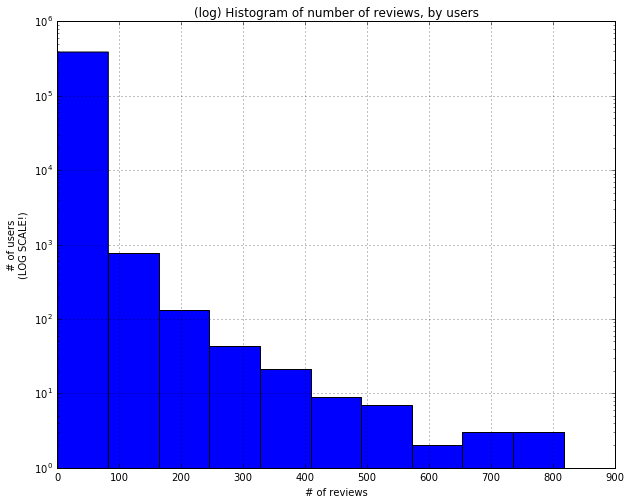

In [204]:
plt.figure(figsize=(10,8))
plt.hist(review_count_by_user['Count'], log=True, cumulative=False);
plt.grid()
plt.xlabel('# of reviews')
plt.ylabel('# of users\n(LOG SCALE!)')
plt.title('(log) Histogram of number of reviews, by users')

## Group reviews by restaurants...

In [207]:
# number of reviews by restaurant (25k distinct restaurants)
review_count_by_biz = sf_obs.groupby('business_id', [gl.aggregate.COUNT()]).sort('Count', ascending=False)
review_count_by_biz[0:10]

business_id,Count
4bEjOyTaDG24SY5TxsaUNQ,5042
zt1TpTuJ6y9n551sw9TaEg,3958
2e2e7WgqU1BnpxmQL5jbfw,3896
sIyHTizqAiGu12XMLX3N3g,3788
aGbjLWzcrnEx2ZmMCFm3EA,3405
Xhg93cMdemu5pAMkDoEdtQ,3086
YNQgak-ZLtYJQxlDwN-qIg,2876
QbmcCE_cLq4WO8ZMKImaLw,2704
tFU2Js_nbIZOrnKfYJYBBg,2589
CZjcFdvJhksq9dy58NVEzw,2576


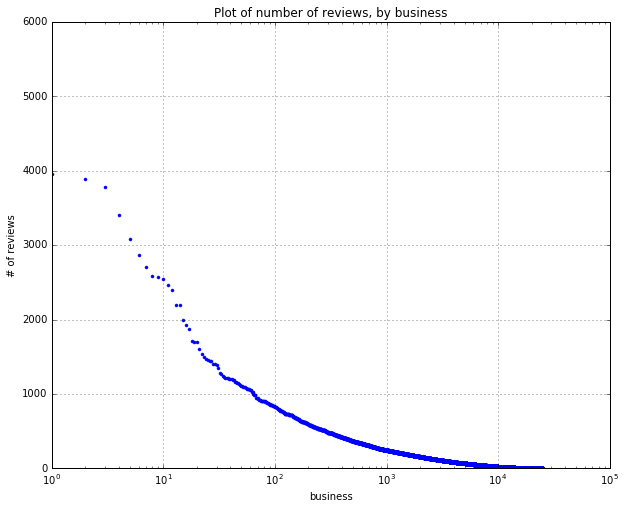

In [208]:
plt.figure(figsize=(10,8))
plt.semilogx(review_count_by_biz['Count'], '.');
plt.grid()
plt.xlabel('business')
plt.ylabel('# of reviews')
plt.title('Plot of number of reviews, by business')

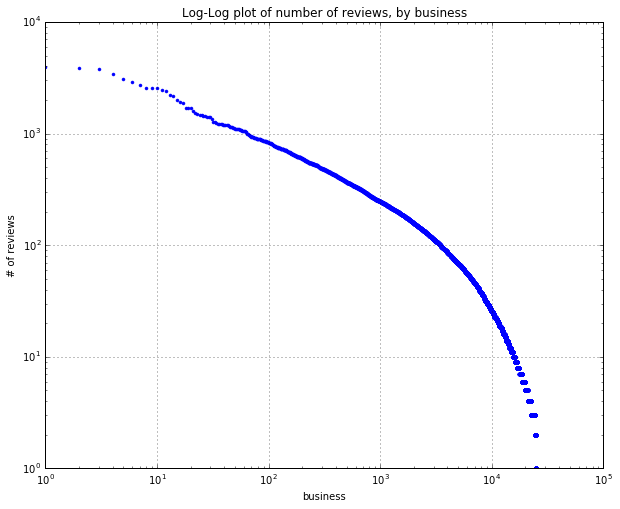

In [209]:
plt.figure(figsize=(10,8))
plt.loglog(review_count_by_biz['Count'], '.');
plt.grid()
plt.xlabel('business')
plt.ylabel('# of reviews')
plt.title('Log-Log plot of number of reviews, by business')

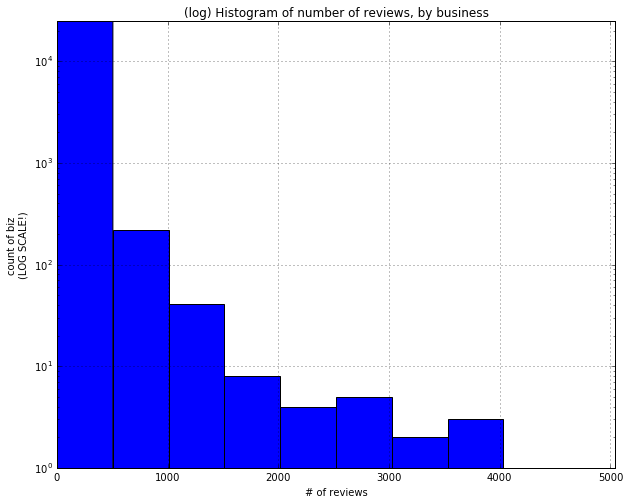

In [210]:
plt.figure(figsize=(10,8))
plt.hist(review_count_by_biz['Count'], log=True);
plt.grid()
plt.autoscale(tight=True)
plt.xlabel('# of reviews')
plt.ylabel('count of biz\n(LOG SCALE!)')
plt.title('(log) Histogram of number of reviews, by business')

## Load in business.json file as 'item_data', for side data factorization...

In [27]:
from create_sidedata import create_sidedata
sf_itemdata = create_sidedata()

running create_sidedata()


# Setup the train/test data split...

In [21]:
sf_obs.shape

(1363242, 3)

In [22]:
sf_obs.column_names()

['user_id', 'business_id', 'stars']

In [23]:
# split the test data via Graphlab's recommender tailored splitter function
train_set, test_set = gl.recommender.util.random_split_by_user(sf_obs,
                                                               'user_id',
                                                               'business_id',
                                                               max_num_users=100)

In [24]:
train_set

user_id,business_id,stars
Ouus3lC3Xk3YRGx4ptd_4A,DW6SI2KxcfXBHeo9jEr4lQ,2
dz_sBsL69aWzsxksT2O_Mg,DW6SI2KxcfXBHeo9jEr4lQ,2
zyI-u0C1YOzp5v1j2wuCOQ,DW6SI2KxcfXBHeo9jEr4lQ,3
vyfsQo-estP8EfiIFMsL6g,DW6SI2KxcfXBHeo9jEr4lQ,3
lxZSVeJz6KEBW1nlA3JKJg,DW6SI2KxcfXBHeo9jEr4lQ,1
CbMCOeeHVeafcD-6-CJrPg,DW6SI2KxcfXBHeo9jEr4lQ,4
Z8DyUMojRhFbLyHBymM_rA,DW6SI2KxcfXBHeo9jEr4lQ,2
sXWvDlMQspjJ1zzr3cEM7Q,DW6SI2KxcfXBHeo9jEr4lQ,2
G8RaaiVzbyRvsBmoUx0VeA,DW6SI2KxcfXBHeo9jEr4lQ,1
f0isFKnJVZVmpdCPNd8Gfw,DW6SI2KxcfXBHeo9jEr4lQ,1


In [25]:
test_set

user_id,business_id,stars
9K013bOSmGBmZqAV2YDfpA,bcW-OuYklAXeEZWBgc7TaA,5
xjZgADf08bQlOQnWwW_IKg,px45x27eir8RyN6YjX-VWQ,4
hMnwV8h15C1sfgVIP0dgQw,LXrq0Fw6MCz70KMA928ldQ,2
NyFFJjymTm1N6pjHp37KiQ,PWG28q4JFOc8FiRBjnfCkA,2
tAM6TS8Mcnqf6Ar4zcxG6A,3ZQmCHGtK6JNHlxaCeOx7g,4
d7Jyyd5lKGoNSV1SoSqZxg,N50HceZf1595UtU867u4uQ,5
RnEZs_qJf2KqosVcA2eUrQ,CKf3mf7fl5sZO9xviHU7lQ,4
-ff8in_34TSOnzLIFYQdaA,KJnVuzpveyDrHARVNZaYVg,1
WJNMh_hUymOX7CDKtCOKUA,d52zg-S0o940WUCK-nNiKw,5
KsHHV9UJl2zzXJ2a04gbbQ,4uGHPY-OpJN08CabtTAvNg,5


# Run the recommender...

In [57]:
# create the recommender (will train during this step)
rec = gl.recommender.factorization_recommender.create(
            train_set,
            user_id='user_id',
            item_id='business_id',
            target='stars',
#             item_data=sf_itemdata
            )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 1363192 observations with 388600 users and 24974 items.

Data prepared in: 3.08026s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 170399 / 1363192 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | No Decrease (4.47474 >= 1.69765)         |

| 4       | 0.0976562         | 0.584329                                 |

| 5       | 0.0488281         | 0.831491                                 |

| 6       | 0.0244141         | 1.06137                                  |

| 7       | 0.012207          | 1.24622                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 0.584329                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 207us        | 1.69602           | 1.30231               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 581.551ms    | 1.58119           | 1.2572                | 0.0976562   |

| 2       | 1.01s        | 1.21103           | 1.10032               | 0.0580668   |

| 3       | 1.40s        | 1.06061           | 1.02974               | 0.042841    |

| 4       | 1.68s        | 0.913813          | 0.955774              | 0.0345267   |

| 5       | 2.00s        | 0.775641          | 0.880453              | 0.029206    |

| 6       | 2.37s        | 0.663122          | 0.81395               | 0.0254734   |

| 10      | 3.60s        | 0.422067          | 0.648821              | 0.017366    |

| 11      | 3.88s        | 0.391121          | 0.624447              | 0.016168    |

| 15      | 5.10s        | 0.31313           | 0.558279              | 0.0128124   |

| 20      | 6.45s        | 0.266009          | 0.514139              | 0.0103259   |

| 25      | 8.06s        | 0.24034           | 0.488392              | 0.00873464  |

| 30      | 9.94s        | 0.224412          | 0.471689              | 0.00761832  |

| 35      | 11.36s       | 0.213491          | 0.459878              | 0.00678655  |

| 40      | 12.82s       | 0.205517          | 0.451052              | 0.00613981  |

| 45      | 14.22s       | 0.19937           | 0.444122              | 0.0056207   |

| 50      | 16.23s       | 0.194465          | 0.438511              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.179285

Final training RMSE: 0.420848

#### Save off the model

In [58]:
rec.save('frec_without_sides')


In [252]:
pwd

u'/Volumes/Macintosh_HD/Users/deanliu/git/Galvanize/capstone_project/traveler_eats_recommender'

# Load the model from disk

In [263]:
mws = gl.load_model('models/frec_with_sides')
mwos= gl.load_model('models/frec_without_sides')

# mws = gl.load_model('models/frec_tmp_ws')
# mwos= gl.load_model('models/frec_tmp_wos')

In [264]:
'Restaurants' in mws.item_side_data_column_names

True

In [254]:
import random

In [270]:
# create a test users
threshold_lo = 5
threshold_hi = 10
test_user = restaurants_by_user[(threshold_lo<restaurants_by_user['count']) &
                                (restaurants_by_user['count']<threshold_hi)] \
                .sample(0.01)[0:1]
print test_user

+------------------------+-------+-------------------------------+
|        user_id         | count |          restaurants          |
+------------------------+-------+-------------------------------+
| xJvZjm6j8aeXG3aUEzwaag |   9   | {'W8Gjzs5mxSU9aA77l-V9fA':... |
+------------------------+-------+-------------------------------+
[1 rows x 3 columns]



In [281]:
test_user[0]['user_id']

'xJvZjm6j8aeXG3aUEzwaag'

In [273]:
simuser_ws = mws.get_similar_users([test_user[0]['user_id']], k=10)
simuser_wsj = simuser_ws.join(restaurants_by_user, on={'user_id':'user_id'}, how='left')
print simuser_wsj.head()

simuser_ns = mwos.get_similar_users([test_user[0]['user_id']], k=10)
simuser_nsj = simuser_ns.join(restaurants_by_user, on={'user_id':'user_id'}, how='left')
print simuser_nsj.head()

Getting similar users completed in 0.018248

+------------------------+------------------------+----------------+------+-------+
|        user_id         |        similar         |     score      | rank | count |
+------------------------+------------------------+----------------+------+-------+
| xJvZjm6j8aeXG3aUEzwaag | bOK-LX6wCR8q1LGBbVw9rQ | 0.999969005585 |  1   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | M24Y07AyCR8hdlC3qMBNDQ | 0.999960422516 |  2   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | 2s-Y1A1G69MmMU1ENmlixA | 0.999959766865 |  3   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | m0FMb8avBMr2E7wdUyhVzA | 0.999956548214 |  4   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | DZlIxaai3wF-YgKP3Me-eA | 0.999954581261 |  5   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | d1gKL5zDbUjcwiKfF1Leug | 0.999946057796 |  6   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | nB_CErCdm_JGGwugQhsqPQ | 0.999945878983 |  7   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | X6l3f1Hye2BEcFG5RZnJ_w | 0.999945759773 |  8   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | c65RuWQ-zqku3NKK---aFw | 0.999944806099 |  9   | 

Getting similar users completed in 0.013062

+------------------------+------------------------+----------------+------+-------+
|        user_id         |        similar         |     score      | rank | count |
+------------------------+------------------------+----------------+------+-------+
| xJvZjm6j8aeXG3aUEzwaag | Lzxx5eJ_WSEr-LrIc2QRPA | 0.982292890549 |  1   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | 7VqXdrmBA0J7TxGzAcNJxA | 0.97577381134  |  2   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | 0MRlubaLu5v3sI4vu_XqDg | 0.964220106602 |  3   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | b0jSP2vzSCJAvVlg_vxwtQ | 0.96025955677  |  4   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | 5fufT4_o8VTovviGAsc9_g | 0.953839600086 |  5   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | ka9L2n3jRx6_PcPun2516A | 0.952230870724 |  6   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | 54cM8ZJgbhn9PjOS0XROMA | 0.95214086771  |  7   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | vXM2lOi0iwegQlbB69VFuw | 0.951331019402 |  8   |   9   |
| xJvZjm6j8aeXG3aUEzwaag | -cxKUTgQsKECicDIKZ_MKA | 0.951191067696 |  9   | 

In [106]:
mws.show()
mwos.show()

Canvas is accessible via web browser at the URL: http://localhost:49546/index.html
Opening Canvas in default web browser.
Canvas is updated and available in a tab in the default browser.


In [137]:
list(simuser_ws['similar','score'][0:5])

[{'score': 0.9998569488525391, 'similar': 'RvA9gntdOj1UfgIO1udKdg'},
 {'score': 0.9998271465301514, 'similar': '1UKOCb-k8oMdTG821GX6gQ'},
 {'score': 0.9998024702072144, 'similar': 'jwouB3jD8kWgGPor3AfI-Q'},
 {'score': 0.9997962117195129, 'similar': 'zRuyGKh-ksUzJ1wqNU46Gw'},
 {'score': 0.9997909665107727, 'similar': 'fBE4NNPviEcn9Gm-lZsZFA'}]

In [130]:
simuser_ws

user_id,similar,score,rank
UFr-WCtnNbX8O3sI7h4qeQ,RvA9gntdOj1UfgIO1udKdg,0.999856948853,1
UFr-WCtnNbX8O3sI7h4qeQ,1UKOCb-k8oMdTG821GX6gQ,0.99982714653,2
UFr-WCtnNbX8O3sI7h4qeQ,jwouB3jD8kWgGPor3AfI-Q,0.999802470207,3
UFr-WCtnNbX8O3sI7h4qeQ,zRuyGKh-ksUzJ1wqNU46Gw,0.99979621172,4
UFr-WCtnNbX8O3sI7h4qeQ,fBE4NNPviEcn9Gm-lZsZFA,0.999790966511,5
UFr-WCtnNbX8O3sI7h4qeQ,FgDirdF5qYQ6dI8U-gh3kA,0.999782323837,6
UFr-WCtnNbX8O3sI7h4qeQ,Q3fFv_ft17OyV-NRF1iQxw,0.999769508839,7
UFr-WCtnNbX8O3sI7h4qeQ,g4luSu3EFv3tmEAj1XrNog,0.999766349792,8
UFr-WCtnNbX8O3sI7h4qeQ,-A6jF_xAyAK3pvjTjzbfIw,0.999759554863,9
UFr-WCtnNbX8O3sI7h4qeQ,Dorg57DfTwyLVvbECTmUOw,0.999751508236,10


In [ ]:
# rec = gl.recommender.create(
#             sf_obj,
#             user_id='user_id',
#             item_id='business_id',
#             target ='stars')

In [39]:
# evaluate 1 datapoint (user=1, business=100) for potential rating
one_datapoint_sf = gl.SFrame({'user_id': [1], 'business_id': [100]})
print "stars:", rec.predict(one_datapoint_sf)[0]   # 4.879

stars: 3.73694314521


In [40]:
rec.list_fields()

['adagrad_momentum_weighting',
 'additional_iterations_if_unhealthy',
 'binary_target',
 'coefficients',
 'data_load_time',
 'init_random_sigma',
 'item_id',
 'item_side_data_column_names',
 'item_side_data_column_types',
 'linear_regularization',
 'max_iterations',
 'model_name',
 'nmf',
 'num_factors',
 'num_features',
 'num_item_side_features',
 'num_items',
 'num_observations',
 'num_tempering_iterations',
 'num_user_side_features',
 'num_users',
 'observation_data_column_names',
 'random_seed',
 'regularization',
 'regularization_type',
 'sgd_convergence_interval',
 'sgd_convergence_threshold',
 'sgd_max_trial_iterations',
 'sgd_sampling_block_size',
 'sgd_step_adjustment_interval',
 'sgd_step_size',
 'sgd_trial_sample_minimum_size',
 'sgd_trial_sample_proportion',
 'side_data_factorization',
 'solver',
 'step_size_decrease_rate',
 'target',
 'tempering_regularization_start_value',
 'track_exact_loss',
 'training_rmse',
 'training_stats',
 'training_time',
 'user_id',
 'user_side_

In [41]:
rec.get('coefficients')['intercept']

3.7369431452062614

In [42]:
# rec['coefficients']  # equivalent to: rec.get('coefficients')
rec.get('coefficients')['user_id']

user_id,linear_terms,factors
Ouus3lC3Xk3YRGx4ptd_4A,0.0327613838017,"[0.0261160954833,0.0263281986117, ..."
dz_sBsL69aWzsxksT2O_Mg,-0.0152220064774,"[-0.0241532307118,-0.0241916514933, ..."
zyI-u0C1YOzp5v1j2wuCOQ,0.0465549193323,"[0.0160138569772,0.0160326808691, ..."
vyfsQo-estP8EfiIFMsL6g,0.0587146058679,"[-0.0107431840152,-0.0103426072747, ..."
lxZSVeJz6KEBW1nlA3JKJg,-0.11037093401,"[-0.0459412224591,-0.0458470769227, ..."
CbMCOeeHVeafcD-6-CJrPg,0.0605444423854,"[-0.0185883156955,-0.018461458385, ..."
Z8DyUMojRhFbLyHBymM_rA,-0.110937416553,"[-0.0106938546523,-0.0105813508853, ..."
sXWvDlMQspjJ1zzr3cEM7Q,-0.0254131220281,"[0.0130900871009,0.0133146680892, ..."
G8RaaiVzbyRvsBmoUx0VeA,-0.00300458748825,"[0.0119381546974,0.0119537906721, ..."
f0isFKnJVZVmpdCPNd8Gfw,-0.226664245129,"[-0.00979323592037,-0.00989496335387, ..."


In [43]:
# rec['coefficients']  # equivalent to: rec.get('coefficients')
rec.get('coefficients')['business_id']

business_id,linear_terms,factors
Yf_mKctDPfMQkig-DavQJw,-0.0407451838255,"[-0.0085883019492,-0.00839034561068, ..."
Hxw3hG8Efg6WXSa5oRJhrA,-0.234818160534,"[-0.06912881881,-0.0693349763751, ..."
KkdkWeTMN8q-xpWD0ckx1Q,0.222354754806,"[-0.0495907403529,-0.0494525320828, ..."
sUwVz00qBevDgt2dhe_KXA,-0.0903140455484,"[-0.0292513202876,-0.0294271633029, ..."
xoYY0F5hrs00h285tWmZZA,-0.0753992125392,"[0.0891507640481,0.0887101069093, ..."
m6JwiGrKrs0XCmH9ij3fmA,-0.060532130301,"[0.0517805144191,0.0518697313964, ..."
BaoMhBMUDnMDud6F2ZgxrA,-0.119151495397,"[-0.0343846902251,-0.0343868993223, ..."
h_1xOfqdfxqNlGOG1oMwKQ,-0.197489455342,"[-0.049904268235,-0.0500828027725, ..."
E4b5OC_6mZ0V7B6Nyjncsg,0.113419637084,"[0.0469928234816,0.0473065190017, ..."
1xu5wFd0TeBg6xNBiRtknw,0.0979582667351,"[-0.071278013289,-0.0715539827943, ..."


In [44]:
business_sf = rec['coefficients']['business_id']
print len(business_sf)                     # 1682
print len(business_sf['factors'][0])       # 8
user_sf = rec['coefficients']['user_id']
print len(user_sf)                      # 943
print len(user_sf['factors'][0])        # 8

25071
8
388600
8
